In [1]:
#importaciones
from IPython.display import HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import _converter
%matplotlib inline 
plt.style.use('default')
import datetime
import math
sns.set(style="whitegrid") # seteando tipo de grid en seaborn

In [2]:
# Leyendo csvs
df_edu = pd.read_csv("../datos_navent_fiuba/fiuba_1_postulantes_educacion.csv")
df_gen_edad = pd.read_csv("../datos_navent_fiuba/fiuba_2_postulantes_genero_y_edad.csv", parse_dates=['fechanacimiento'])
df_vistas = pd.read_csv("../datos_navent_fiuba/fiuba_3_vistas.csv", parse_dates=['timestamp'])
df_postulaciones = pd.read_csv("../datos_navent_fiuba/fiuba_4_postulaciones.csv", parse_dates=['fechapostulacion'])
df_avisos_detalle = pd.read_csv("../datos_navent_fiuba/fiuba_6_avisos_detalle.csv")


# ¿En qué horas se registra la mayor cantidad de postulaciones/vistas?

In [3]:
df_vistas["hour"] = df_vistas["timestamp"].dt.hour
df_postulaciones["hour"] = df_postulaciones["fechapostulacion"].dt.hour
df_postulaciones["date"] =df_postulaciones["fechapostulacion"].dt.date

In [4]:
date_ini = datetime.date(year=2018,month=2,day=27)
date_fin = datetime.date(year=2018,month=2,day=28)
df_periodo_postulaciones = df_postulaciones[df_postulaciones["fechapostulacion"].dt.date >= date_ini]
df_periodo_vistas = df_vistas[(df_vistas["timestamp"].dt.date >= date_ini) & (df_vistas["timestamp"].dt.date <= date_fin)]

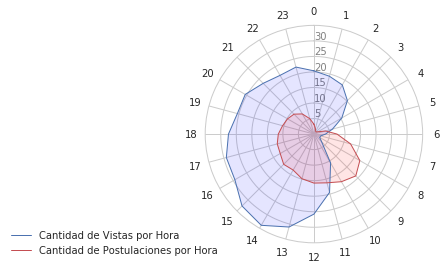

In [5]:
categories = range(0, 24) # 0 a 23 horas

# numero de variables categoricas
N = len(categories)

from math import pi
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Inicializar el grafico
ax = plt.subplot(111, polar=True)
 
# Corremos el inicio para que comienze como un reloj (corro el origen 90°):
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Dibujamos un eje por categoria
plt.xticks(angles[:-1], categories)

# Dibujo labels en y
ax.set_rlabel_position(0)
plt.yticks([5000,10000,15000,20000,25000,30000], ["5","10","15","20","25","30"], color="grey", size=10)
plt.ylim(0,35000)

# Serie de datos para las vistas por hora
values2 = list(df_periodo_vistas.groupby("hour")["idAviso"].count())
values2 += values2[:1]
ax.plot(angles, values2, linewidth=1, linestyle='solid', label="Cantidad de Vistas por Hora")
ax.fill(angles, values2, 'b', alpha=0.1)

# Serie de datos para las postulaciones por hora
values = list(df_periodo_postulaciones.groupby("hour")["idaviso"].count())
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid',color = "C2", label="Cantidad de Postulaciones por Hora")
ax.fill(angles, values, 'r', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# ¿Cómo es la distribución de edades de los postulantes?

In [6]:
# limpieza de fechas invalidas
df_gen_edad["fechanacimiento"] = pd.to_datetime(df_gen_edad["fechanacimiento"], errors="coerce")

def calc_edad(x):    
    if (pd.isnull(x)):
        return -1
    return math.floor((datetime.datetime.today()-x).days / 365)

# calculo edad para cada postulante
df_gen_edad["edad"] = df_gen_edad["fechanacimiento"].apply(calc_edad)

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


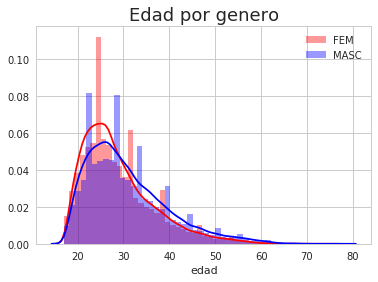

In [7]:
df_gen_edad_valida = df_gen_edad.loc[(17 <= df_gen_edad['edad']) & (df_gen_edad['edad'] <= 80)]

df_edad_fem = df_gen_edad_valida.loc[df_gen_edad_valida['sexo'] == 'FEM']
df_edad_masc = df_gen_edad_valida.loc[df_gen_edad_valida['sexo'] == 'MASC']
#df_edad_no_declara = df_gen_edad_valida.loc[df_gen_edad_valida['sexo'] == 'NO_DECLARA']

g = sns.distplot(df_edad_fem['edad'], color='red', label='FEM')
g = sns.distplot(df_edad_masc['edad'], color='blue', label='MASC')
#g = sns.distplot(df_edad_no_declara['edad'], color='green', label='NO_DECLARA')
g.set_title("Edad por genero", fontsize=18)
g.legend()

# ¿Cuáles areas tienen mayor postulaciones por nivel educativo?

In [8]:
orden_nombre = {
    "Doctorado":0,
    "Master":1,
    "Posgrado":2,
    "Universitario":3,
    "Terciario/Técnico":4,
    "Secundario":5,
    "Otro":6
}

orden_estado = {
    "Graduado":0,
    "En Curso":1,
    "Abandonado":2,
}

df_edu["prioridad_nom"] = df_edu["nombre"].apply(lambda nombre: orden_nombre.get(nombre))
df_edu["prioridad_est"] = df_edu["estado"].apply(lambda estado: orden_estado.get(estado))

df_edu.sort_values(by= ["idpostulante","prioridad_est","prioridad_nom"],inplace= True)

df_edu_unicos_max = df_edu.drop_duplicates(subset = "idpostulante",keep= "first")

df_edu_max_postulaciones = df_edu_unicos_max.merge(df_postulaciones, on = "idpostulante")

df_aviso_corto = df_avisos_detalle[["idaviso","tipo_de_trabajo","nivel_laboral","nombre_area"]]

df_max_post_detalle = df_edu_max_postulaciones.merge(df_aviso_corto, on = "idaviso")

top_10_areas_graduados_secundario = df_max_post_detalle[df_max_post_detalle["nombre"] == "Secundario"] \
                                        .groupby("nombre_area")['idpostulante']\
                                        .count() \
                                        .sort_values(ascending=False) \
                                        .head(10)

g = sns.barplot(x=top_10_areas_graduados_secundario.values, y=top_10_areas_graduados_secundario.index, orient='h')
g.set_title("Graduados de secunadario por area", fontsize=15)
g.set_xlabel("Cantidad de graduados", fontsize=12)
g.set_ylabel("Nombre del Area", fontsize=12)

Text(0,0.5,'Nombre del Area')

Error in callback <function post_execute at 0x7f8d95da1758> (for post_execute):


ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

<Figure size 432x288 with 1 Axes>

In [9]:

top_10_areas_graduados_secundario = df_max_post_detalle[(df_max_post_detalle["nombre"] == "Secundario") & (df_max_post_detalle["estado"] == "Graduado")] \
                                        .groupby("nombre_area")['idpostulante']\
                                        .count() \
                                        .sort_values(ascending=False) \
                                        .head(10)

g = sns.barplot(x=top_10_areas_graduados_secundario.values, y=top_10_areas_graduados_secundario.index, orient='h')
g.set_title("Graduados de secunadario por area", fontsize=15)
g.set_xlabel("Cantidad de graduados", fontsize=12)
g.set_ylabel("Nombre del Area", fontsize=12)

Text(0,0.5,'Nombre del Area')

Error in callback <function post_execute at 0x7f8d95da1758> (for post_execute):


ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

<Figure size 432x288 with 1 Axes>

In [10]:

top_10_areas_graduados_doctorado = df_max_post_detalle[(df_max_post_detalle["nombre"] == "Doctorado") & (df_max_post_detalle["estado"] == "Graduado")] \
                                        .groupby("nombre_area")['idpostulante']\
                                        .count() \
                                        .sort_values(ascending=False) \
                                        .head(10)
                
g = sns.barplot(x=top_10_areas_graduados_doctorado.values, y=top_10_areas_graduados_doctorado.index, orient='h')
g.set_title("Graduados de Doctorado por area", fontsize=15)
g.set_xlabel("Cantidad de graduados", fontsize=12)
g.set_ylabel("Nombre del Area", fontsize=12)

Text(0,0.5,'Nombre del Area')

Error in callback <function post_execute at 0x7f8d95da1758> (for post_execute):


ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

<Figure size 432x288 with 1 Axes>

# ¿Qué tipo de trabajo eligen los postulantes según la educación alcanzada?

Text(0,0.5,'Tipo de Trabajo')

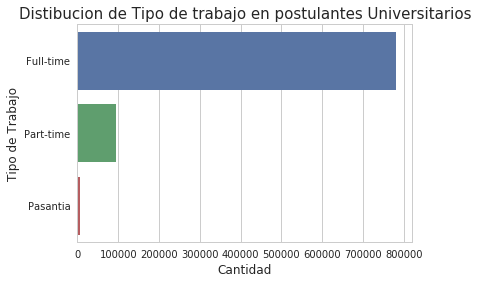

In [11]:
top3_tipo_trabajo_universitario = df_max_post_detalle[df_max_post_detalle["nombre"] == "Universitario"]\
                                 .groupby("tipo_de_trabajo")['idpostulante']\
                                 .count().sort_values(ascending=False).head(3)
g = sns.barplot(x=top3_tipo_trabajo_universitario.values, y=top3_tipo_trabajo_universitario.index, orient="h")    
g.set_title("Distibucion de Tipo de trabajo en postulantes Universitarios", fontsize=15)
g.set_xlabel("Cantidad", fontsize=12)
g.set_ylabel("Tipo de Trabajo", fontsize=12)

Text(0,0.5,'Tipo de Trabajo')

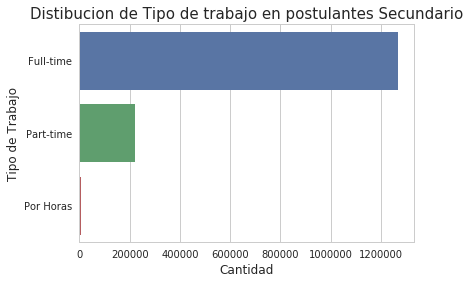

In [12]:
top3_tipo_trabajo_universitario = df_max_post_detalle[df_max_post_detalle["nombre"] == "Secundario"]\
                                 .groupby("tipo_de_trabajo")['idpostulante']\
                                 .count().sort_values(ascending=False).head(3)
g = sns.barplot(x=top3_tipo_trabajo_universitario.values, y=top3_tipo_trabajo_universitario.index, orient="h")    
g.set_title("Distibucion de Tipo de trabajo en postulantes Secundario", fontsize=15)
g.set_xlabel("Cantidad", fontsize=12)
g.set_ylabel("Tipo de Trabajo", fontsize=12)

Text(0,0.5,'Tipo de Trabajo')

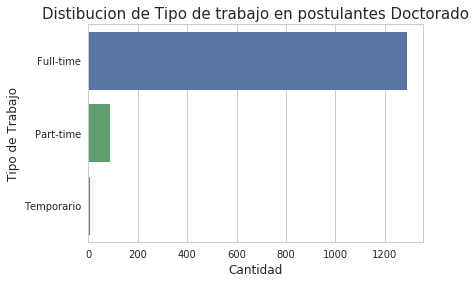

In [13]:
top3_tipo_trabajo_universitario = df_max_post_detalle[df_max_post_detalle["nombre"] == "Doctorado"]\
                                 .groupby("tipo_de_trabajo")['idpostulante']\
                                 .count().sort_values(ascending=False).head(3)
g = sns.barplot(x=top3_tipo_trabajo_universitario.values, y=top3_tipo_trabajo_universitario.index, orient="h")    
g.set_title("Distibucion de Tipo de trabajo en postulantes Doctorado", fontsize=15)
g.set_xlabel("Cantidad", fontsize=12)
g.set_ylabel("Tipo de Trabajo", fontsize=12)

# ¿Qué tipo de trabajo eligen los postulantes según su sexo?

In [14]:
id_gen_corto = df_gen_edad_valida[["idpostulante","sexo"]]
df_sexo_tipo_trabajo =df_max_post_detalle.merge(id_gen_corto,on= "idpostulante")[["sexo","tipo_de_trabajo"]]

In [15]:
df_fem_tipo_trabajo = df_sexo_tipo_trabajo[df_sexo_tipo_trabajo["sexo"] == "FEM"]
top3_fem_tipo_trabajo= df_fem_tipo_trabajo.groupby(["tipo_de_trabajo"])\
                      .count()\
                      .sort_values(by= "sexo",ascending=False)\
                      .head(2)
total= float(top3_fem_tipo_trabajo.sum())
top3_fem_tipo_trabajo["porcentaje"] = top3_fem_tipo_trabajo["sexo"].apply(lambda x: round(x/total*100))

In [90]:
df_masc_tipo_trabajo = df_sexo_tipo_trabajo[df_sexo_tipo_trabajo["sexo"] == "MASC"]
top3_masc_tipo_trabajo= df_masc_tipo_trabajo.groupby(["tipo_de_trabajo"])\
                      .count()\
                      .sort_values(by= "sexo",ascending=False)\
                      .head(2)
total= float(top3_masc_tipo_trabajo.sum())
top3_masc_tipo_trabajo["porcentaje"] = top3_masc_tipo_trabajo["sexo"].apply(lambda x: round(x/total*100))

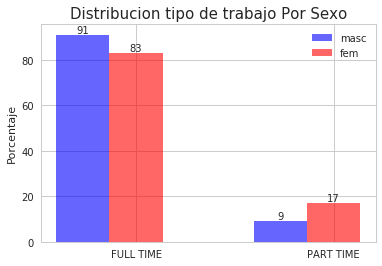

In [17]:
N = 2
ind = np.arange(N)  # la locacion x del grupo
width = 0.27      # el ancho de la barra

fig = plt.figure()
ax = fig.add_subplot(111)

#genero los valores del grafico
mascvals = list(top3_masc_tipo_trabajo["porcentaje"])
rectmasc = ax.bar(ind, mascvals, width, color='b',alpha= 0.6)
femvals = list(top3_fem_tipo_trabajo["porcentaje"])
rectfem = ax.bar(ind+width, femvals, width, color='r',alpha= 0.6)

ax.set_title("Distribucion tipo de trabajo Por Sexo", fontsize=15)
ax.set_ylabel('Porcentaje')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('FULL TIME', 'PART TIME') )
ax.legend( (rectmasc[0], rectfem), ('masc', 'fem') )

#creo la etiquetade los grupos
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rectmasc)
autolabel(rectfem)

# ¿Influye el sexo en el nivel educativo alcanzado?

In [86]:
edu_max_genero= df_edu_unicos_max.merge(id_gen_corto, on= "idpostulante")
edu_masc= edu_max_genero[edu_max_genero["sexo"]== "MASC"].groupby("nombre")["idpostulante",].count()
total= float(edu_masc["idpostulante"].sum())
edu_masc["porcentaje"] = edu_masc["idpostulante"].apply(lambda x: round(x/total*100))
edu_masc=edu_masc.reset_index()
edu_masc["prioridad"]= edu_masc["nombre"].apply(lambda nom: orden_nombre.get(nom))
edu_masc = edu_masc.sort_values(by= "prioridad",ascending= False)
edu_masc

,nombre,idpostulante,porcentaje,prioridad
2,Otro,1672,2.0,6
4,Secundario,45692,51.0,5
5,Terciario/Técnico,11981,14.0,4
6,Universitario,25729,29.0,3
3,Posgrado,2381,3.0,2
1,Master,1217,1.0,1
0,Doctorado,57,0.0,0


In [87]:
edu_fem= edu_max_genero[edu_max_genero["sexo"]== "FEM"].groupby("nombre")["idpostulante",].count()
total= float(edu_fem["idpostulante"].sum())
edu_fem["porcentaje"] = edu_fem["idpostulante"].apply(lambda x: round(x/total*100))
edu_fem=edu_fem.reset_index()
edu_fem["prioridad"]= edu_fem["nombre"].apply(lambda nom: orden_nombre.get(nom))
edu_fem = edu_fem.sort_values(by= "prioridad",ascending= False)
edu_fem

,nombre,idpostulante,porcentaje,prioridad
2,Otro,2073,2.0,6
4,Secundario,44763,46.0,5
5,Terciario/Técnico,15500,16.0,4
6,Universitario,31445,33.0,3
3,Posgrado,2136,2.0,2
1,Master,755,1.0,1
0,Doctorado,56,0.0,0


In [94]:
N = 7
ind = np.arange(N)  # la locacion x del grupo
width = 0.27      # el ancho de la barra

fig = plt.figure()
ax = fig.add_subplot(111)

#genero los valores del grafico
mascvals = list(edu_masc["porcentaje"])
rectmasc = ax.bar(ind, mascvals, width, color='b',alpha= 0.6)
femvals = list(edu_fem["porcentaje"])
rectfem = ax.bar(ind+width, femvals, width, color='r',alpha= 0.6)

ax.set_title("Distribucion Del Nivel Educativo alcanzado por Sexo", fontsize=15)
ax.set_ylabel('Porcentaje')
ax.set_xticks(ind+width)
ax.set_xticklabels( list(edu_masc["nombre"]) )
ax.legend( (rectmasc[0], rectfem), ('masc', 'fem') )

#creo la etiquetade los grupos
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rectmasc)
autolabel(rectfem)

Error in callback <function post_execute at 0x7f8d95da1758> (for post_execute):


ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

<Figure size 432x288 with 1 Axes>

este grafico hay que agrandarlooo y hacer que se vea bien